# Idea

Random Forests are great at predicting stuff.
However, you do give some stuff up compared to linear models.
Most importantly: interpretability and uncertainty estimates.

Past work:
* Prediction uncertainty based on distribution of predictions of underlying trees (e.g. "probability" y is true based on the percentage of trees that predicts 1)
* Prediction of global feature importance based on shuffling of features
* Prediction of indidividual feature importances based on shapley values

However, people still struggle with getting a grasp on how well these feature importances can be trusted.

I have a very simple idea: why don't we see how these permutation importances / shapley values vary over the trees and use those to also get an indication of uncertainty in global/local feature importances!

Someone else must have thought of this before me. I just haven't looked well enough to find their work yet. So here I go exploring it by myself:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
N_ESTIMATORS = 100

In [3]:
df = pd.read_csv('../data/titanic.csv')

In [4]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [5]:
X_cols = set(df.columns) - set(('Survived','Name'))

In [6]:
X = pd.get_dummies(df[X_cols])
X.drop(['Sex_male'],axis=1,inplace=True)

In [7]:
y = df.Survived.values

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=N_ESTIMATORS)
clf.fit(X,y)
clf.score(X,y)

0.9819616685456595

# RFPIMP

In [9]:
from rfpimp import *

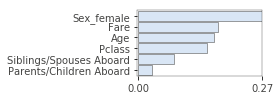

In [10]:
imp = importances(clf, X, y , n_samples=-1)
viz = plot_importances(imp)
viz.view()

# Permutation Importance Uncertainty

In [11]:
tree_feature_perm = pd.DataFrame(index=range(N_ESTIMATORS),columns=X.columns)

In [12]:
score_tree = [tree.score(X,y) for tree in clf.estimators_]

In [13]:
for f in X.columns:
    X_shuff = X.copy()
    X_shuff[f] = np.random.permutation(X_shuff[f])
    tree_feature_perm[f] = [tree.score(X_shuff,y) for tree in clf.estimators_]
        
        

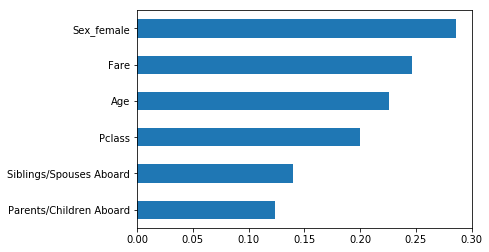

In [14]:
((clf.score(X,y) - tree_feature_perm.mean())
.sort_values()
.plot.barh())

**Ok so consistent with rfpimp**

**Explore uncertainty**

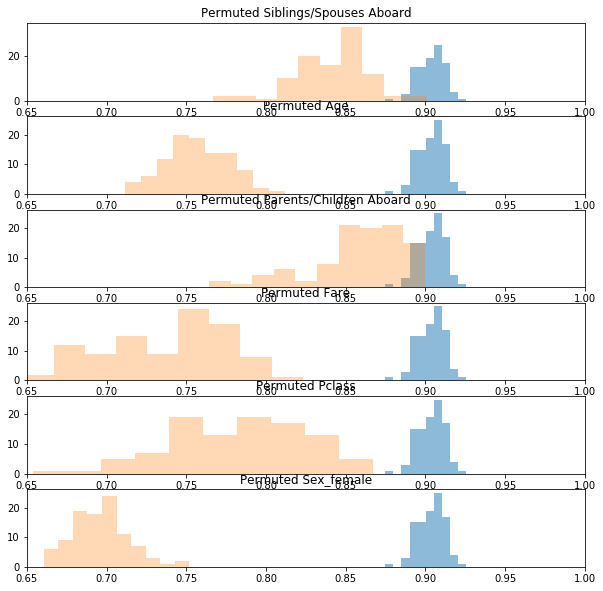

In [15]:

fig = plt.figure(figsize=[10,10])

for i, f in enumerate(X.columns):
    ax = fig.add_subplot(len(X.columns),1,i+1)
    ax.hist(score_tree,alpha=0.5,label='Original')
    ax.hist(tree_feature_perm[f],alpha=0.3,label=f'Permuted: {f}')
    ax.set_title(f'Permuted {f}')
    ax.set_xlim([0.65,1])

**See: Sex_Female is much more clearly a drop in performance than #of Parents/Children aboard**

# Uncertainty of Shapley Values

In [18]:
import shap
shap.initjs()

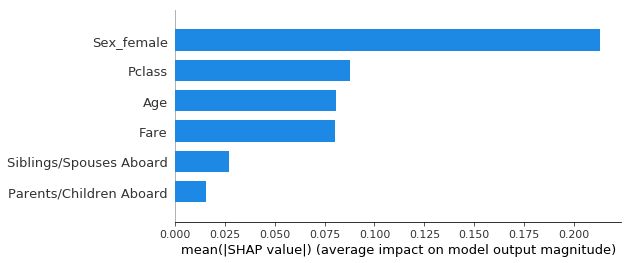

In [19]:
# forest explainer
explainer = shap.TreeExplainer(clf)
shap_clf = explainer.shap_values(X)[1]
shap.summary_plot(shap_clf, X,plot_type='bar')

**Consistent with RFPIMP and my manual calc.
But now we get more, see below:**

In [20]:
shap.force_plot(explainer.expected_value[1], shap_clf[0,:], 
                X.iloc[0,:], link="logit")

**Lets see if we can express uncertainty to these**

In [21]:
# tree explainer
tree_shap = np.zeros((X.shape[0], X.shape[1], N_ESTIMATORS))
for i in range(N_ESTIMATORS):
    explainer = shap.TreeExplainer(clf.estimators_[i])
    tree_shap[:,:,i] = explainer.shap_values(X)[1]

In [35]:
tree_shap[0].mean(1) #take first observation and then take feature mean over all trees

array([-0.09443322, -0.20176702,  0.02921765, -1.83050914, -2.03265191,
       -3.50751137])

**!!!!!!!!!!!!!!!!!!!**

**Hmmm... shaps of trees dont add up to shaps of forest...although they should I think**

Let's continue as if everything was fine. Lets circle back to the issue of shapley values of the tree and the forest later...

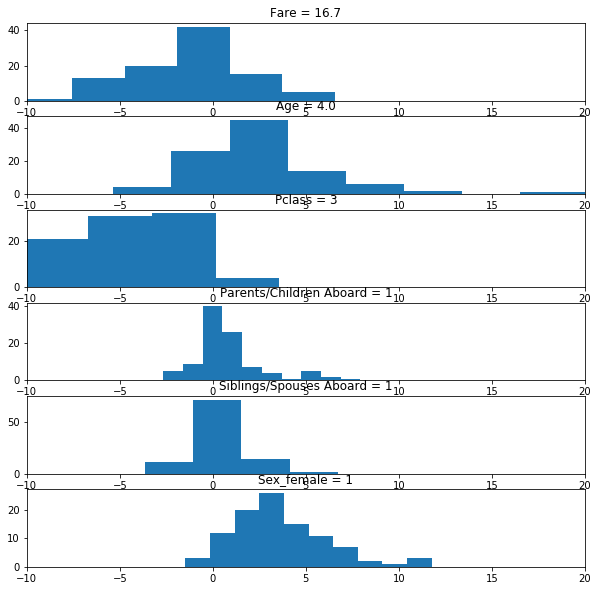

In [215]:
# plot for passenger J uncertainty of shapleys for each feature

j = 10

fig = plt.figure(figsize=[10,10])

for i, f in enumerate(X.columns):
    ax = fig.add_subplot(len(X.columns),1,i+1)
    ax.hist(tree_shap[j,i,:])
    ax.set_xlim((-10,20))
    ax.set_title(f'{f} = {X.loc[j,f]}')

**Wow: now we even have an idea of how well we can trust each shapley value for each observation**

Note that the shapley values per tree,feature are correlated. So you can't simply add random values from each distribution

# more figs to generalize

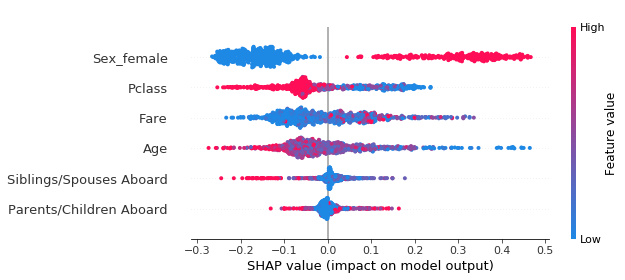

In [192]:
shap.summary_plot(shap_clf, X)

In [193]:
shap.force_plot(explainer.expected_value[1], 
                shap_clf, X, link="logit")